# The CIFAR-10 Chalange

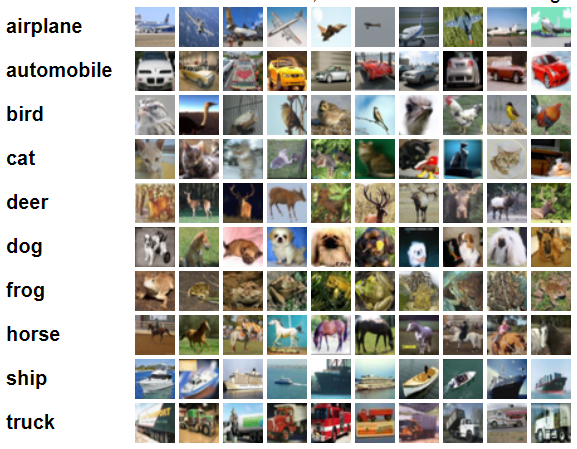

## Overview
In this document I will explain in details my approach of solving the CIFAR-10 challenge.
I will describe in details the problem, the solution, and describe the way I choose the different parameters.
I will begin with the bottom line: Using my own personal laptop machine which is a Window-7 64-bit with 8GB of RAM, and Intel Core i5-5300U CPU of 2.30 GHZ, I have successfully matched **70.41%** of the images in about 53 minutes.

## The problem
CIFAR-10 is a dataset consist of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The test images are composed of 1000 randomly selected images from each class. The training images contains 5,000 images from each class in random order.
The goal of this competition, is to build an algorithm which takes a random image and classify it to one of the 10 classes with as high as possible accuracy.

## The Algorithm

### Overview
Basically we are talking about a classifier algorithm. This algorithm should use the training images to build a classifier model, and then apply the test images on this model to test how good this model really is.
The following chart shows the building block of the algorithm:

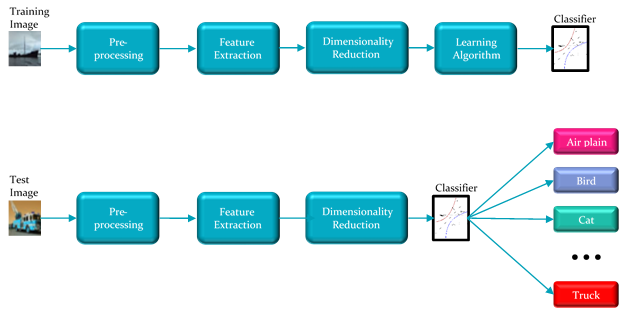

#### Training Phase
1. **Training Image:** The algorithm start with a set of 50,000 classified training images.
2. **Preprocessing:** These images are send to the preprocessing phase, in which they are prepared for the next phases. For example cleaning the images from noise, so that the noise will not affect the next phases.
3. **Feature Extraction:** Now, each image is ready for feature extraction phase, in which it is represented as a vector
4. **Dimensionality Reduction:** Once the images are converted into vectors, the algorithm reduce the dimension of these vectors. This dimension reduction is done under the assumption that similar images (from the same class) will have similar (or close) vectors.
5. **Learning Algorithm:** Now, these reduced vectors are ready to be sent to the learning algorithm, which receives these vectors of images a long with the label of each image, and calculate the classifier model. This model will be used later for the test images.

#### Testing Phase
Once the model classifier is ready, it can used by the test images. 
These test images are going through the same pipeline of: preprocessing, feature extraction, and dimension reduction. 
Then they are ready to be sent to the model classifier created in phase 5 above, to be classified. 
The solution is than compared to the real classes of the test images and the accuracy level and confusion matrix are calculated. 

### Implementation

#### Helper Methods

##### Import the relevant libraries

In [1]:
######################################################################################
## Import the relevant libraries
## ==============================
import numpy
import time
import calendar
from six.moves import cPickle as pickle
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
######################################################################################

##### General parameters

In [2]:
######################################################################################
## General parameters:
## ===================
imageSize = 32  #The size of the original image - in pixels - assuming this is a square image
channels = 3    #The number of channels of the image. A RBG color image, has 3 channels
classes = 10    #The number of classes available for this dataset
trainingDataSize = 50000    #The number of images in the training set
testDataSize = 10000        #The number of images in the test set
trainigDataFiles = ('./dataset/data_batch_1', './dataset/data_batch_2', './dataset/data_batch_3', './dataset/data_batch_4','./dataset/data_batch_5') #An array of filenames containing the training data set
testDataFile = './dataset/test_batch' #The filename containing the test set
pcaFileName = 'pca' #The PCS filename
svmFileName = 'svm' #The SVM filename
######################################################################################

##### HOG Parameters

In [3]:
######################################################################################
## HOG Parameters:
## ================
winSize = imageSize
blockSize = 12
blockStride = 4
cellSize = 4
nbins = 18
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = True
hog = cv2.HOGDescriptor((winSize,winSize),(blockSize, blockSize),(blockStride,blockStride),(cellSize,cellSize),nbins,derivAperture, winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradient)
######################################################################################

##### SVM parameters

In [4]:
######################################################################################
##SVM parameters:
##===============
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setC(0.1)
svm.setGamma(0.1)
######################################################################################

##### PCA parameters

In [5]:
######################################################################################
##PCA parameters:
##==================
pcaDim = 3000
######################################################################################

##### Load the data from the given filename

In [6]:
######################################################################################
def loadData(filename):
    '''
    Load the data from the given filename

    Parameters:
    -----------
    filename: string
        The name of the file containing the data to load

    Returns:
    --------
    theSet['data']:     array of images
    theSet['labels']:   array of labels
    '''
    f = open(filename, 'rb')
    theSet = pickle.load(f)
    f.close()

    return theSet['data'], theSet['labels']
#####################################################################################

##### Convert the images from CIFAR-10 format, to an array of 10000 images each is 32 X 32 X 3 size

In [7]:
#####################################################################################
def convertImages(origImages):
    '''
    Convert the images from CIFAR-10 format, to an array of 10000 images each is 32 X 32 X 3 size

    Parameters:
    -----------
    origImages: array
        array of images in the CIFAR-10 format

    Returns:
    --------
    images:     array of images each in 32 X 32 X 3 size
    '''
    images = np.reshape(origImages,(-1, channels, imageSize, imageSize))
    images = np.transpose(images, (0,2,3,1))

    return images
#####################################################################################

##### Load the test data

In [8]:
######################################################################################
def loadTestData(filename):
    '''
    Load the test data

    Parameters:
    -----------
    filename: string
        The name of the file containing the test data

    Returns:
    --------
    testImages: array of images of the test data
    testLabels: array of labels of the test data
    '''

    origTestImages, testLabels = loadData(filename)
    testImages = convertImages(origTestImages)

    return testImages, testLabels
######################################################################################

##### Load all the training data from all files

In [9]:
######################################################################################
def loadTrainingData(filenames):
    '''
    Load all the training data from all files

    Parameters:
    -----------
    filenames: array of string
        An array The name of the file containing the data to load

    Returns:
    --------
    trainingImages: array of the training set images
    trainingLabels: array of the training set labels
    '''

    #Pre-allocate the arrays
    trainingImages = np.zeros(shape=[trainingDataSize, imageSize, imageSize, channels], dtype=numpy.uint8)
    trainingLabels = np.zeros(shape=[trainingDataSize], dtype=int)

    start=0
    for fileName in filenames:
        origImages, labels = loadData(fileName)
        images = convertImages(origImages)

        numOfImages = len(images);
        end = start + numOfImages;
        trainingImages[start:end, :] = images
        trainingLabels[start:end] = labels
        start = end

    return trainingImages, trainingLabels
#####################################################################################

##### Returns the current time in seconds since EPOC

In [10]:
#####################################################################################
def currentTime():
    '''
    Returns the current time in seconds since EPOC
    Used to measure how much time each phase took

    Returns:
    --------
    the current time in second since EPOC
    '''

    return calendar.timegm(time.gmtime())
#####################################################################################

##### Calculate the HOG descriptors of the given images

In [11]:
#####################################################################################
def calcHOG(images):
    '''
    Calculate the HOG descriptors of the given images

    Parameters:
    -----------
    images: an array of images
        The images to which a HOG calculation should be applied

    Returns:
    --------
    hogDescriptors: an array of HOG vectors, 5832 components each
    '''

    hogDescriptors = []
    for image in images:
        hogDescriptors.append( hog.compute(image) )

    hogDescriptors = np.squeeze(hogDescriptors)
    return hogDescriptors
#####################################################################################

#### Algorithm Implementation

##### Training Phase

###### First load the data into two arrays:

In [12]:
print("Loading the training set..."),
tik = currentTime()
trainingImages, trainingLabels = loadTrainingData(trainigDataFiles)
print("Took: " + str(currentTime()-tik) + " sec" )

Loading the training set... Took: 1 sec


###### Create a HOG descriptor from these images

In [13]:
print("Creating HOG descriptors from the training set..."),
tik = currentTime()
trainHogDescriptors = calcHOG(trainingImages)
print("Took: " + str(currentTime() - tik) + " sec")

Creating HOG descriptors from the training set... Took: 15 sec


###### Reduce the dimension of the HOG descriptors to 3000

In [14]:
print("Reducing the dimension of the HOG descriptors to " + str(pcaDim) + "..."),
tik = currentTime()
pca = PCA(pcaDim)
trainHogProjected = pca.fit_transform(trainHogDescriptors)
print("Took: " + str(currentTime() - tik) + " sec")

Reducing the dimension of the HOG descriptors to 3000... Took: 606 sec


###### Save it as a pca file

In [15]:
    print("Save it as a PCA file..."),
    tik = currentTime()
    pcaFile = open(pcaFileName, 'wb')
    pickle.dump(pca, pcaFile)
    pcaFile.close()
    print("Took: " + str(currentTime() - tik) + " sec")

Save it as a PCA file... Took: 8 sec


###### Train the SVM model using the reduced HOG descriptor

In [16]:
print("Training the SVM model using the reduced HOG descriptor..."),
tik = currentTime()
svm.train(np.asarray(trainHogProjected), cv2.ml.ROW_SAMPLE, np.asarray(trainingLabels))
svm.save(svmFileName)
print("Took: " + str(currentTime() - tik) + " sec")

Training the SVM model using the reduced HOG descriptor... Took: 2418 sec


##### Testing phase

###### Load the test set

In [17]:
print("Loading the test set..."),
tik = currentTime()
testImages, testLabels = loadTestData(testDataFile)
print("Took: " + str(currentTime() - tik) + " sec")

Loading the test set... Took: 1 sec


###### Create HOG descriptors from the test set

In [18]:
print("Creating HOG descriptors from the test set..."),
tik = currentTime()
testHogDescriptors = calcHOG(testImages);
print("Took: " + str(currentTime() - tik) + " sec")

Creating HOG descriptors from the test set... Took: 3 sec


###### Reducing the dimension of the HOG descriptors

In [19]:
print("Reducing the dimension of the HOG descriptors to " + str(pcaDim) + "..."),
tik = currentTime()
testHogProjected = pca.transform(testHogDescriptors)
print("Took: " + str(currentTime() - tik) + " sec")

Reducing the dimension of the HOG descriptors to 3000... Took: 6 sec


###### Classify the test set

In [20]:
print("Classifying the test set..."),
tik = currentTime()
testResponse = svm.predict(np.asarray(testHogProjected))[1].ravel()
print("Took: " + str(currentTime() - tik) + " sec")

Classifying the test set... Took: 419 sec


###### Calculate the confusion matrix

In [21]:
print ("Confusion matrix:")
print ("=================")
confusionMatrix = confusion_matrix(testLabels, testResponse)
print(confusionMatrix)

Confusion matrix:
[[761   9  68  19  27   8  13   3  70  22]
 [ 21 827   8  13  12   4  19   2  42  52]
 [ 69   8 591  80  88  70  42  18  27   7]
 [ 34  11 120 527  76 141  42  21  15  13]
 [ 27  11  79  94 657  24  41  46  17   4]
 [ 16   9  85 220  68 518  24  48   7   5]
 [ 22  18  44  71  34  32 764   4   9   2]
 [ 14   4  38  67  73  60   9 709  11  15]
 [ 51  24  22  17  11  10   6   6 833  20]
 [ 32  47  11  22  16   8   7  13  26 818]]


###### Calculate accuracy

In [22]:
print ("======================================")
accuracy = (np.asarray(testLabels) == testResponse).mean()
print("Percentage Accuracy: %.2f %%" % (accuracy*100))
print ("======================================")

Percentage Accuracy: 70.05 %
